In [1]:
'''步驟總覽
設定 Kaggle Notebook 環境
下載並準備資料集
轉換標註格式為 YOLO
建立 data.yaml 設定檔
下載 YOLOv8 並訓練模型
測試訓練好的模型'''

'步驟總覽\n設定 Kaggle Notebook 環境\n下載並準備資料集\n轉換標註格式為 YOLO\n建立 data.yaml 設定檔\n下載 YOLOv8 並訓練模型\n測試訓練好的模型'

In [2]:
#安裝套件
!pip install torch>=2.1.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install tensorflow==2.17.0
!pip install scikit-learn==1.5.0
!pip install pytorch-lightning==2.5.0
!pip install ultralytics

# 安裝 paddleocr 和 paddlepaddle
!pip install paddlepaddle-gpu
!pip install "paddleocr>=2.0.1"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 81.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.4/819.4 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.5.0.post0
    Uninstalling pytorch-lightning-2.5.0.post0:
      Successfully uninstalled pytorch-lightning-2.5.0.post0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.7/914.7 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.9/758.9 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os

dataset_path = "/kaggle/input/car-plate-detection"

print("📂 檢查資料集內容:", os.listdir(dataset_path))

📂 檢查資料集內容: ['annotations', 'images']


In [4]:
os.makedirs("/kaggle/working/images/train", exist_ok=True)
print("資料夾建立成功")

資料夾建立成功


In [5]:
import os
import glob
import shutil
import random
import xml.etree.ElementTree as ET

# ✅ 確保類別名稱和 data.yaml 一致
classes = ["licence"]  # 注意: 確保 data.yaml 內也是 "licence"

# ✅ 設定標註與影像路徑
annotation_dir = "/kaggle/input/car-plate-detection/annotations"
image_dir = "/kaggle/input/car-plate-detection/images"
output_img_dir = "/kaggle/working/images/train"
output_label_dir = "/kaggle/working/labels/train"

# ✅ 確保輸出資料夾存在
os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

def convert_xml_to_yolo_and_copy_images(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    img_filename = root.find("filename").text
    img_path = os.path.join(image_dir, img_filename)

    # ✅ 檢查影像是否存在
    if not os.path.exists(img_path):
        print(f"⚠️ 影像檔案不存在：{img_path}，跳過！")
        return

    # 複製影像到目標資料夾
    output_img_path = os.path.join(output_img_dir, img_filename)

    # ✅ 如果目標檔案已存在，則跳過複製
    if not os.path.exists(output_img_path):
        shutil.copy(img_path, output_img_path)
    else:
        print(f"⚠️ 影像檔案已存在，跳過：{img_filename}")

    # ✅ 讀取影像大小
    size = root.find("size")
    img_w = int(size.find("width").text)
    img_h = int(size.find("height").text)

    yolo_annotations = []

    for obj in root.findall("object"):
        label = obj.find("name").text
        if label not in classes:
            print(f"⚠️ {img_filename} 的標註 `{label}` 未包含在 classes 清單內，已跳過")
            continue
        
        class_id = classes.index(label)
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        # ✅ 轉換為 YOLO 格式 (相對座標)
        x_center = (xmin + xmax) / 2 / img_w
        y_center = (ymin + ymax) / 2 / img_h
        width = (xmax - xmin) / img_w
        height = (ymax - ymin) / img_h

        yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    # ✅ 確保 `.txt` 檔案名稱對應影像名稱
    txt_filename = os.path.splitext(img_filename)[0] + ".txt"
    txt_file = os.path.join(output_label_dir, txt_filename)

    if yolo_annotations:
        with open(txt_file, "w") as f:
            f.write("\n".join(yolo_annotations))
    else:
        print(f"⚠️ {txt_filename} 無有效標註，已跳過")

# 🔄 開始轉換 XML 並複製影像
xml_files = glob.glob(f"{annotation_dir}/*.xml")
for xml in xml_files:
    convert_xml_to_yolo_and_copy_images(xml)

print("✅ XML 轉換及影像複製完成！")

# 訓練與驗證資料夾
train_img_dir = "/kaggle/working/images/train"
val_img_dir = "/kaggle/working/images/val"
train_label_dir = "/kaggle/working/labels/train"  # 訓練標註資料夾
val_label_dir = "/kaggle/working/labels/val"  # 驗證標註資料夾

os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

# 取得所有影像檔案
all_images = glob.glob(f"{output_img_dir}/*.jpg") + glob.glob(f"{output_img_dir}/*.png")

# 80% 訓練，20% 驗證
random.shuffle(all_images)
split_index = int(0.8 * len(all_images))
train_images = all_images[:split_index]
val_images = all_images[split_index:]

# 分別移動圖片與標註檔
for img_path in train_images:
    output_img_path = os.path.join(train_img_dir, os.path.basename(img_path))
    
    # 如果圖片已存在，則跳過
    if not os.path.exists(output_img_path):
        shutil.copy(img_path, train_img_dir)
    else:
        print(f"⚠️ 訓練集影像 {os.path.basename(img_path)} 已存在，跳過")
    
    label_path = os.path.join(output_label_dir, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
    
    # 檢查標註檔案是否存在，並移動
    if os.path.exists(label_path):
        target_label_path = os.path.join(train_label_dir, os.path.basename(label_path))
        if label_path != target_label_path:
            shutil.copy(label_path, train_label_dir)  # 只在目標檔案不存在時才複製

for img_path in val_images:
    output_img_path = os.path.join(val_img_dir, os.path.basename(img_path))
    
    # 如果圖片已存在，則跳過
    if not os.path.exists(output_img_path):
        shutil.copy(img_path, val_img_dir)
    else:
        print(f"⚠️ 驗證集影像 {os.path.basename(img_path)} 已存在，跳過")
    
    label_path = os.path.join(output_label_dir, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
    
    # 檢查標註檔案是否存在，並移動
    if os.path.exists(label_path):  # 確保標註檔案存在
        target_label_path = os.path.join(val_label_dir, os.path.basename(label_path))
        if label_path != target_label_path:
            shutil.copy(label_path, val_label_dir)  # 只在目標檔案不存在時才複製
    else:
        print(f"⚠️ 驗證集圖片 {os.path.basename(img_path)} 沒有對應的標註檔案，請檢查")

print("✅ 訓練與驗證數據集已成功分割！")

✅ XML 轉換及影像複製完成！
⚠️ 訓練集影像 Cars344.png 已存在，跳過
⚠️ 訓練集影像 Cars202.png 已存在，跳過
⚠️ 訓練集影像 Cars266.png 已存在，跳過
⚠️ 訓練集影像 Cars70.png 已存在，跳過
⚠️ 訓練集影像 Cars421.png 已存在，跳過
⚠️ 訓練集影像 Cars246.png 已存在，跳過
⚠️ 訓練集影像 Cars384.png 已存在，跳過
⚠️ 訓練集影像 Cars371.png 已存在，跳過
⚠️ 訓練集影像 Cars14.png 已存在，跳過
⚠️ 訓練集影像 Cars360.png 已存在，跳過
⚠️ 訓練集影像 Cars322.png 已存在，跳過
⚠️ 訓練集影像 Cars427.png 已存在，跳過
⚠️ 訓練集影像 Cars82.png 已存在，跳過
⚠️ 訓練集影像 Cars408.png 已存在，跳過
⚠️ 訓練集影像 Cars329.png 已存在，跳過
⚠️ 訓練集影像 Cars387.png 已存在，跳過
⚠️ 訓練集影像 Cars3.png 已存在，跳過
⚠️ 訓練集影像 Cars214.png 已存在，跳過
⚠️ 訓練集影像 Cars348.png 已存在，跳過
⚠️ 訓練集影像 Cars109.png 已存在，跳過
⚠️ 訓練集影像 Cars31.png 已存在，跳過
⚠️ 訓練集影像 Cars19.png 已存在，跳過
⚠️ 訓練集影像 Cars208.png 已存在，跳過
⚠️ 訓練集影像 Cars278.png 已存在，跳過
⚠️ 訓練集影像 Cars265.png 已存在，跳過
⚠️ 訓練集影像 Cars407.png 已存在，跳過
⚠️ 訓練集影像 Cars98.png 已存在，跳過
⚠️ 訓練集影像 Cars200.png 已存在，跳過
⚠️ 訓練集影像 Cars182.png 已存在，跳過
⚠️ 訓練集影像 Cars269.png 已存在，跳過
⚠️ 訓練集影像 Cars39.png 已存在，跳過
⚠️ 訓練集影像 Cars209.png 已存在，跳過
⚠️ 訓練集影像 Cars26.png 已存在，跳過
⚠️ 訓練集影像 Cars383.png 已存在，跳過
⚠️ 訓練集影像 Cars192.png 已存在，跳過
⚠️ 訓練集影像 Cars

In [6]:
yaml_content = """\
train: /kaggle/working/images/train
val: /kaggle/working/images/val

nc: 1
names: ['licence']
"""

with open("/kaggle/working/data.yaml", "w") as f:
    f.write(yaml_content)

print("✅ data.yaml 設定檔已建立！")

✅ data.yaml 設定檔已建立！


In [7]:
from ultralytics import YOLO

# 下載 YOLOv8 預訓練權重
model = YOLO("yolov8m.pt")

# 訓練 YOLO
model.train(data="/kaggle/working/data.yaml", 
            epochs=100, 
            imgsz=640,
            batch=16,  # 增加 batch size
            lr0=0.0005, lrf=0.2, # 設定學習率
            patience=20, # 若 20 個 epoch 沒有進步則提前停止
            augment=True,  # 啟用影像增強
            workers=0)  # 設定 num_workers=0，避免 multiprocessing 錯誤

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 49.7M/49.7M [00:00<00:00, 202MB/s]


Ultralytics 8.3.74 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/data.yaml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.4MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/labels/train... 433 images, 0 backgrounds, 0 corrupt: 100%|██████████| 433/433 [00:00<00:00, 468.17it/s]

train: New cache created: /kaggle/working/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/labels/val... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<00:00, 489.53it/s]

val: New cache created: /kaggle/working/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.87G      1.676      3.141      1.455          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all         87         94     0.0308      0.649     0.0255     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.89G      1.671       1.56      1.413          1        640: 100%|██████████| 28/28 [00:22<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         87         94   3.83e-05     0.0106   2.14e-05   1.29e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       6.9G      1.719      1.507      1.472          2        640: 100%|██████████| 28/28 [00:22<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         94   0.000538     0.0426   0.000193   7.42e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.84G      1.689      1.336       1.49          2        640: 100%|██████████| 28/28 [00:22<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         87         94   0.000538     0.0426   0.000193   7.42e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.79G      1.693      1.386      1.479          4        640: 100%|██████████| 28/28 [00:23<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         87         94   0.000658      0.138    0.00037   0.000132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.79G      1.695      1.317      1.504          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         87         94   0.000717     0.0532    0.00026   7.02e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.79G      1.608      1.296      1.421          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         87         94    0.00545      0.447     0.0042     0.0017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.83G      1.601      1.221      1.399          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         94       0.76      0.596       0.65      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.81G       1.66      1.203      1.406          2        640: 100%|██████████| 28/28 [00:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         87         94       0.71       0.67        0.7      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.79G      1.515      1.191      1.392          3        640: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         94      0.725      0.701      0.789      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.79G      1.524      1.162      1.433          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         87         94      0.639      0.564      0.566      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.79G      1.482      1.091      1.373          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         87         94      0.834      0.641      0.764       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.83G      1.535      1.129        1.4          2        640: 100%|██████████| 28/28 [00:23<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         87         94      0.864      0.691      0.791      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.83G      1.455      1.084      1.342          2        640: 100%|██████████| 28/28 [00:23<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         87         94      0.752      0.819       0.79      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.79G       1.45      1.059      1.359          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         87         94      0.843      0.684      0.782      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.83G       1.49      1.053      1.338          3        640: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         87         94      0.833      0.796       0.85      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.79G      1.482     0.9851      1.373          2        640: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         87         94      0.893      0.796      0.856      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.83G      1.473     0.9541      1.348          4        640: 100%|██████████| 28/28 [00:23<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         94      0.793      0.816      0.853      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.79G      1.475     0.9604      1.354          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         87         94      0.771      0.789      0.814      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.82G      1.415     0.9761      1.304          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         87         94      0.848      0.798      0.848      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.83G      1.498     0.9542      1.384          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         87         94      0.854      0.734      0.839      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.81G      1.457     0.9894      1.356          4        640: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         87         94      0.907      0.835      0.919      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.83G      1.378      0.903      1.336          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         87         94      0.856      0.862      0.896      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.78G       1.38     0.9246      1.284          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         87         94      0.926      0.803      0.909      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.83G      1.409      1.024      1.326          1        640: 100%|██████████| 28/28 [00:22<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         94       0.82      0.926      0.917      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.83G      1.373     0.8693      1.263          2        640: 100%|██████████| 28/28 [00:22<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         87         94       0.92      0.856      0.937      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.83G      1.278     0.8439      1.235          6        640: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         87         94      0.877      0.836      0.913      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.83G      1.374     0.8383      1.285          4        640: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         87         94      0.902      0.872      0.942      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.83G      1.272     0.8339      1.247          0        640: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         87         94       0.91      0.858      0.932      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.78G      1.349     0.8626      1.282          5        640: 100%|██████████| 28/28 [00:23<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         87         94      0.883      0.804      0.887      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.79G      1.321     0.8083      1.255          4        640: 100%|██████████| 28/28 [00:22<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         87         94      0.835       0.86      0.924      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.79G       1.36     0.8032      1.279          1        640: 100%|██████████| 28/28 [00:22<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         87         94      0.828      0.872       0.92      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.79G      1.318     0.8288      1.255          1        640: 100%|██████████| 28/28 [00:22<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         94      0.894        0.9      0.946      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.79G      1.211     0.8654      1.195          0        640: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         87         94      0.877      0.907      0.933       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.79G      1.291     0.8192      1.247          3        640: 100%|██████████| 28/28 [00:22<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         87         94      0.842      0.926      0.942      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.83G      1.268     0.8033      1.218          1        640: 100%|██████████| 28/28 [00:22<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         87         94      0.911      0.872      0.953      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.78G      1.225     0.7979      1.213          5        640: 100%|██████████| 28/28 [00:23<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         87         94      0.883      0.957      0.958      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.83G      1.283     0.8428      1.258          3        640: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         87         94      0.913      0.894      0.944      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.84G       1.25     0.7477      1.195          2        640: 100%|██████████| 28/28 [00:23<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         87         94      0.917      0.942      0.963      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.79G      1.223      0.722      1.213          3        640: 100%|██████████| 28/28 [00:23<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         87         94      0.871      0.933       0.95       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.78G      1.184     0.7282      1.188          2        640: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         87         94      0.917       0.94      0.956      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.83G      1.222     0.7675      1.226          4        640: 100%|██████████| 28/28 [00:22<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         87         94      0.905      0.947      0.952      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.83G      1.256     0.7631      1.233          4        640: 100%|██████████| 28/28 [00:23<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         87         94       0.93      0.904      0.975      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.83G      1.315      0.758      1.278          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         87         94      0.958      0.966      0.982      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.83G      1.163     0.7105      1.166          0        640: 100%|██████████| 28/28 [00:23<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         94      0.925       0.92      0.935      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.79G      1.214     0.7356      1.214          2        640: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         87         94      0.928      0.962      0.978      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.78G      1.226     0.7235      1.222          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         94      0.935      0.936      0.954       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.79G      1.202       0.71        1.2          2        640: 100%|██████████| 28/28 [00:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         94      0.948      0.963      0.974      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.83G      1.193     0.7136      1.216          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         87         94      0.939      0.936      0.978      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.79G       1.14     0.7068      1.195          3        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         94      0.947      0.947      0.979      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.84G      1.081     0.6388      1.137          0        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         94      0.947      0.947      0.965       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.82G      1.166     0.6747      1.161          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         87         94      0.968      0.936      0.986      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.84G      1.201     0.7173      1.211          3        640: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         87         94       0.93      0.915      0.967      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.83G      1.109     0.7172      1.127          0        640: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         94      0.946      0.926      0.979      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.84G      1.122     0.6726       1.15          2        640: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         87         94      0.931      0.947      0.982      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.84G      1.114       0.64      1.161          2        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         87         94      0.924      0.979      0.981      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.79G      1.082     0.6351      1.147          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         94      0.938      0.947      0.985      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.82G      1.119     0.6454      1.155          2        640: 100%|██████████| 28/28 [00:23<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         87         94      0.928      0.955      0.975       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.83G      1.153     0.6481      1.164          4        640: 100%|██████████| 28/28 [00:23<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         94      0.917      0.968      0.974      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.83G       1.11      0.636      1.162          3        640: 100%|██████████| 28/28 [00:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         87         94      0.911      0.957      0.967      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.82G      1.105     0.6416      1.142          3        640: 100%|██████████| 28/28 [00:24<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         94      0.937       0.95      0.973      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.78G      1.125     0.6448      1.124          2        640: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         87         94      0.947      0.989      0.988      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.81G      1.109     0.6179       1.14          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         87         94      0.965      0.957      0.987      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.83G      1.101      0.654      1.168          2        640: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         87         94      0.934      0.968      0.979      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.78G      1.054     0.5956      1.133          3        640: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         87         94      0.948      0.973      0.988      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.83G      1.045     0.5909      1.117          4        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         94       0.96      0.957      0.977      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.84G      1.126     0.6136      1.144          4        640: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         94      0.963      0.979      0.989        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.79G      1.059     0.5904      1.105          2        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         87         94      0.912      0.957      0.967      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.84G      1.081     0.5963      1.149          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         87         94      0.979      0.983      0.993      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.79G      1.048       0.59      1.118          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         94      0.989      0.982      0.994      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.84G      1.035     0.5613      1.108          2        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         94      0.959      0.983      0.993      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.84G      1.031     0.5872      1.107          4        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         94      0.968      0.971      0.992       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.84G      1.007     0.5737      1.105          2        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         87         94      0.968      0.968      0.988      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.84G     0.9697     0.5503      1.075          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         94       0.93      0.988      0.984      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.79G      1.049     0.6418      1.106          5        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         94      0.953      0.957      0.988      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.84G       1.04     0.6101      1.105          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         87         94      0.949      0.989      0.982      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.84G      1.011     0.5435      1.114          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         87         94      0.958      0.973      0.984      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.81G      1.059     0.5698      1.119          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         94      0.964      0.979      0.988      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.84G     0.9816     0.5464      1.072          2        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         94      0.966      0.989      0.991      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       6.8G     0.9762     0.5549      1.067          2        640: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         94      0.954      0.979      0.961      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.79G      1.011     0.5633      1.091          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         94      0.949       0.99      0.981      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.83G      1.058     0.6137      1.101          3        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         87         94      0.966      0.989      0.991      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.83G      1.025     0.5314      1.121          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         94      0.929          1      0.987      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.82G     0.9855     0.5294      1.085          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         94      0.963      0.979      0.992      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.84G     0.9761      0.534      1.096          3        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         94      0.968      0.976       0.99      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.79G     0.9423     0.5503      1.061          0        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         87         94      0.958      0.983       0.99      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.82G      0.972     0.5419      1.115          3        640: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all         87         94      0.967          1      0.993      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.83G     0.9259     0.5158      1.054          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         94      0.951      0.979      0.977      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.83G     0.9224     0.5237      1.071          1        640: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         87         94      0.968      0.976      0.992      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.83G     0.9908     0.5431      1.102          4        640: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         87         94      0.969      0.987      0.994      0.761


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.79G     0.9554     0.5133       1.07          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         94      0.989      0.985      0.993      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.82G     0.9307     0.5101      1.106          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         94      0.988      0.968      0.994      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.84G     0.9133     0.4706      1.056          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         87         94       0.96      0.979      0.992      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.82G     0.9243     0.4913      1.078          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         87         94      0.954          1      0.994      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.78G     0.9256     0.4896      1.067          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         94      0.989      0.997      0.994      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.83G      1.014     0.5017      1.208          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         87         94      0.994          1      0.995      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.83G     0.9458     0.4696      1.082          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         87         94      0.978      0.989      0.993      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.83G      0.844     0.4402       1.05          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         87         94      0.989      0.996      0.995      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.83G     0.8773     0.4537      1.056          1        640: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         87         94          1      0.999      0.995       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.84G     0.8786     0.4553       1.03          1        640: 100%|██████████| 28/28 [00:22<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         87         94      0.985      0.989      0.994      0.764



100 epochs completed in 0.754 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.74 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


                   all         87         94      0.959      0.994      0.994      0.771


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 19.5ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x794fda928760>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

download https://paddleocr.bj.bcebos.com/PP-OCRv4/chinese/ch_PP-OCRv4_det_infer.tar to /root/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer/ch_PP-OCRv4_det_infer.tar


100%|██████████| 4780/4780 [00:18<00:00, 257.31it/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/chinese/ch_PP-OCRv4_rec_infer.tar to output/rec_plate/ch_PP-OCRv4_rec_infer.tar


100%|██████████| 10720/10720 [00:20<00:00, 534.78it/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:15<00:00, 133.73it/s]

[2025/02/11 18:00:31] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='output/rec_plate', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='/usr/local/lib/pyth

[2025/02/11 18:00:32] ppocr WARNING: The first GPU is used for inference by default, GPU ID: 0
[2025/02/11 18:00:33] ppocr WARNING: The first GPU is used for inference by default, GPU ID: 0

image 1/1 /kaggle/input/car-plate-detection/images/Cars136.png: 448x640 1 licence, 46.5ms
Speed: 1.7ms preprocess, 46.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
[2025/02/11 18:00:35] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.6862382888793945
[2025/02/11 18:00:35] ppocr DEBUG: cls num  : 0, elapsed : 0
[2025/02/11 18:00:35] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06


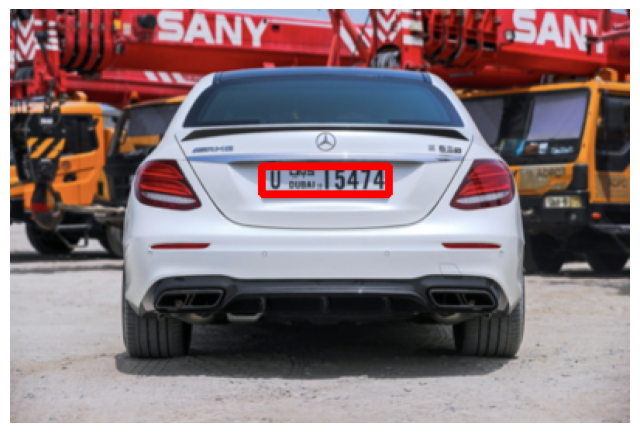

車牌 1: 

image 1/1 /kaggle/input/car-plate-detection/images/Cars396.png: 640x480 1 licence, 38.7ms
Speed: 1.7ms preprocess, 38.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)
[2025/02/11 18:00:35] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.014571428298950195
[2025/02/11 18:00:35] ppocr DEBUG: cls num  : 1, elapsed : 0.08100271224975586
[2025/02/11 18:00:35] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09208321571350098


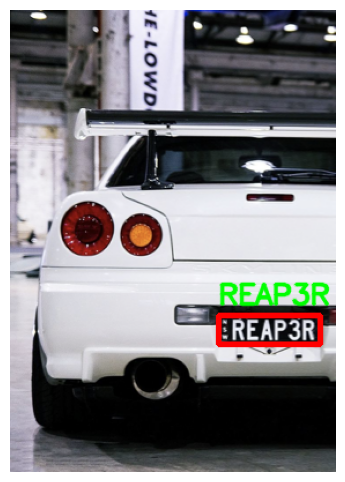

車牌 1: REAP3R

image 1/1 /kaggle/input/car-plate-detection/images/Cars47.png: 480x640 2 licences, 38.7ms
Speed: 2.0ms preprocess, 38.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
[2025/02/11 18:00:36] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.010773897171020508
[2025/02/11 18:00:36] ppocr DEBUG: cls num  : 0, elapsed : 0
[2025/02/11 18:00:36] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06
[2025/02/11 18:00:36] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.009442329406738281
[2025/02/11 18:00:36] ppocr DEBUG: cls num  : 0, elapsed : 0
[2025/02/11 18:00:36] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


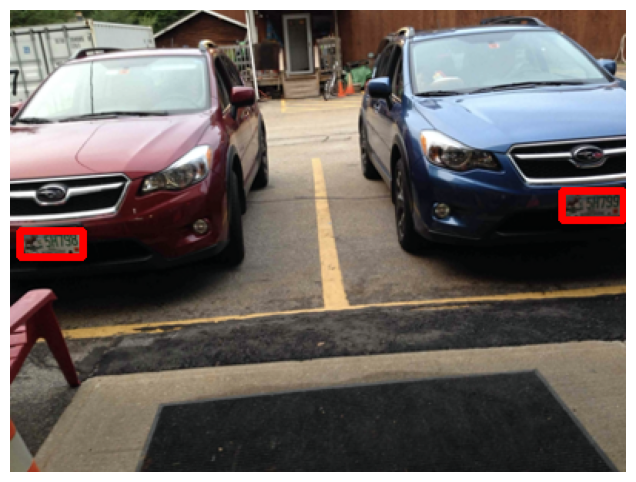

車牌 1: 
車牌 2: 

image 1/1 /kaggle/input/car-plate-detection/images/Cars354.png: 448x640 1 licence, 28.0ms
Speed: 1.7ms preprocess, 28.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
[2025/02/11 18:00:36] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.010286808013916016
[2025/02/11 18:00:36] ppocr DEBUG: cls num  : 0, elapsed : 0
[2025/02/11 18:00:36] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06


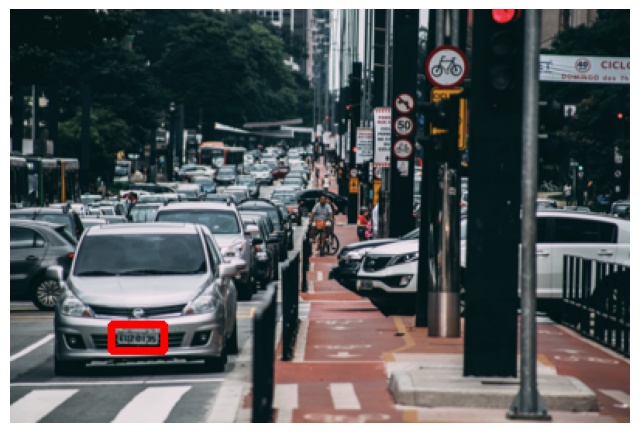

車牌 1: 

image 1/1 /kaggle/input/car-plate-detection/images/Cars315.png: 480x640 1 licence, 28.6ms
Speed: 1.7ms preprocess, 28.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
[2025/02/11 18:00:36] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.011307239532470703
[2025/02/11 18:00:36] ppocr DEBUG: cls num  : 1, elapsed : 0.006595134735107422
[2025/02/11 18:00:36] ppocr DEBUG: rec_res num  : 1, elapsed : 0.009798526763916016


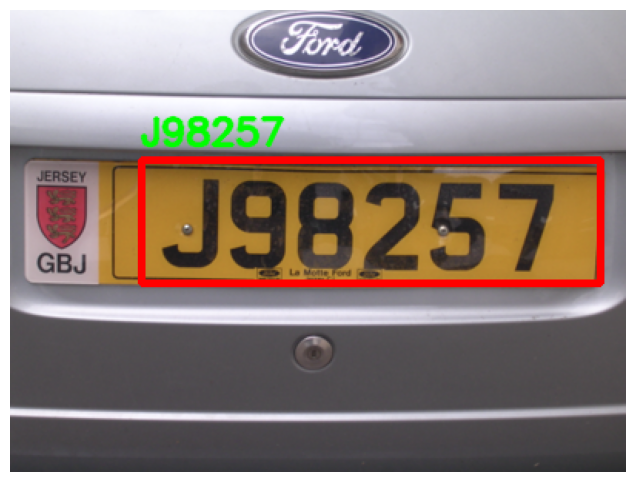

車牌 1: J98257

image 1/1 /kaggle/input/car-plate-detection/images/Cars16.png: 384x640 1 licence, 40.3ms
Speed: 1.5ms preprocess, 40.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
[2025/02/11 18:00:37] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.011148929595947266
[2025/02/11 18:00:37] ppocr DEBUG: cls num  : 0, elapsed : 0
[2025/02/11 18:00:37] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06


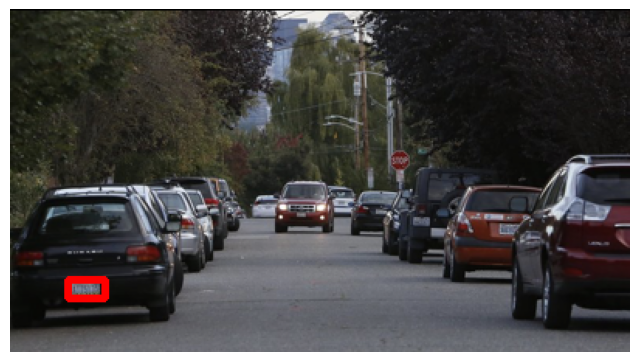

車牌 1: 

image 1/1 /kaggle/input/car-plate-detection/images/Cars87.png: 480x640 2 licences, 28.6ms
Speed: 2.1ms preprocess, 28.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
[2025/02/11 18:00:37] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.010586023330688477
[2025/02/11 18:00:37] ppocr DEBUG: cls num  : 0, elapsed : 0
[2025/02/11 18:00:37] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06
[2025/02/11 18:00:37] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.009955883026123047
[2025/02/11 18:00:37] ppocr DEBUG: cls num  : 0, elapsed : 0
[2025/02/11 18:00:37] ppocr DEBUG: rec_res num  : 0, elapsed : 1.6689300537109375e-06


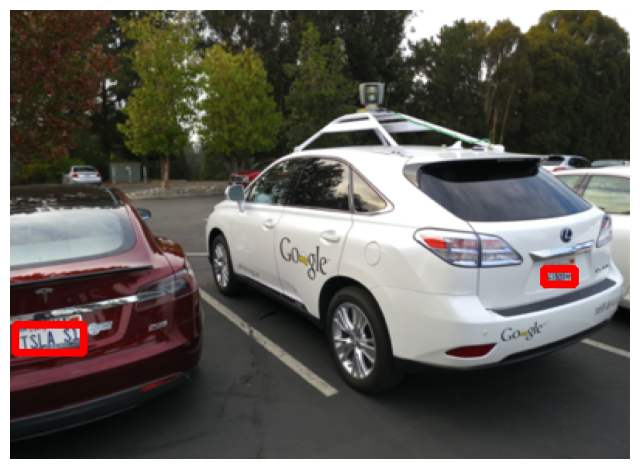

車牌 1: 
車牌 2: 

image 1/1 /kaggle/input/car-plate-detection/images/Cars367.png: 448x640 1 licence, 27.9ms
Speed: 1.9ms preprocess, 27.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
[2025/02/11 18:00:37] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.010389328002929688
[2025/02/11 18:00:37] ppocr DEBUG: cls num  : 1, elapsed : 0.0066182613372802734
[2025/02/11 18:00:37] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0090484619140625


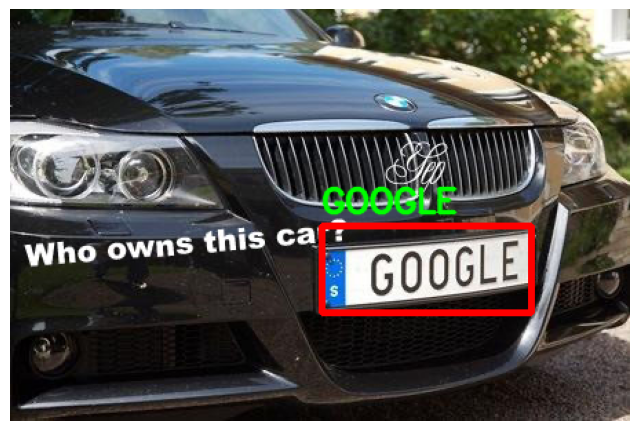

車牌 1: GOOGLE

image 1/1 /kaggle/input/car-plate-detection/images/Cars230.png: 384x640 1 licence, 25.7ms
Speed: 1.5ms preprocess, 25.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
[2025/02/11 18:00:37] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.010843515396118164
[2025/02/11 18:00:37] ppocr DEBUG: cls num  : 1, elapsed : 0.006770133972167969
[2025/02/11 18:00:37] ppocr DEBUG: rec_res num  : 1, elapsed : 0.00926661491394043


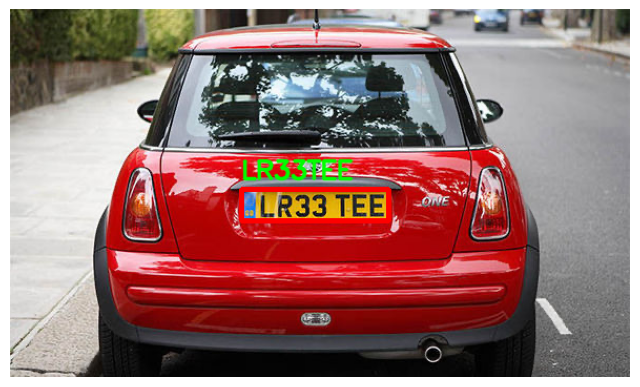

車牌 1: LR33TEE

image 1/1 /kaggle/input/car-plate-detection/images/Cars38.png: 640x640 1 licence, 37.8ms
Speed: 2.1ms preprocess, 37.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
[2025/02/11 18:00:38] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.01154017448425293
[2025/02/11 18:00:38] ppocr DEBUG: cls num  : 1, elapsed : 0.006858348846435547
[2025/02/11 18:00:38] ppocr DEBUG: rec_res num  : 1, elapsed : 0.009758949279785156


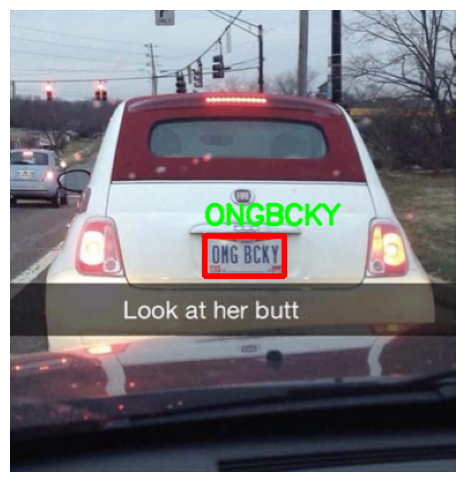

車牌 1: ONGBCKY


In [8]:
import numpy as np
from ultralytics import YOLO
import cv2
import random
import glob
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import font_manager
from paddleocr import PaddleOCR, draw_ocr

# 設定自訂字體
font_path = '/kaggle/input/fontchinese/Open_Data/Fonts/TW-Sung-98_1.ttf'
prop = font_manager.FontProperties(fname=font_path)

# 設定 PaddleOCR，使用自訂字典
ocr = PaddleOCR(use_angle_cls=True, lang="ch", rec_model_dir="output/rec_plate")

# 載入 YOLO 訓練好的模型
model = YOLO("runs/detect/train/weights/best.pt")

# 取得所有圖片
image_paths = glob.glob("/kaggle/input/car-plate-detection/images/*.png") + \
              glob.glob("/kaggle/input/car-plate-detection/images/*.jpg")

# 隨機選擇最多 10 張圖片測試
num_images = min(10, len(image_paths))
random_images = random.sample(image_paths, num_images)

for img_path in random_images:
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 🔹 使用 YOLO 偵測車牌（設定 conf 置信度門檻）
    results = model(img_path, conf=0.4, iou=0.4)

    detected_text_list = []

    for result in results:
        boxes = result.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].int().tolist()
            conf = box.conf[0].item()

            # 擷取車牌區域
            plate_img = img[y1:y2, x1:x2]

            # 🔹 影像處理（降噪 + 二值化）
            gray_plate = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
            gray_plate = cv2.GaussianBlur(gray_plate, (5, 5), 0)  # 去雜訊
            enhanced_plate = cv2.equalizeHist(gray_plate)  # 增強對比
            resized_plate = cv2.resize(enhanced_plate, (300, 100))  # 調整大小


            # 🔹 轉換格式（OpenCV → PIL）
            plate_pil = Image.fromarray(cv2.cvtColor(resized_plate, cv2.COLOR_GRAY2RGB))

            # 🔹 OCR 辨識車牌文字
            # 轉換 PIL 圖片為 NumPy 陣列（確保格式正確）
            plate_np = np.array(plate_pil)

            # OCR 辨識（確保輸入為 NumPy 陣列）
            ocr_results = ocr.ocr(plate_np, cls=True) or []
            detected_text = "".join([word[1][0] for line in ocr_results if line for word in line if word])

            # 繪製邊界框
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 3)
            cv2.putText(img_rgb, detected_text, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)

            detected_text_list.append(detected_text)

    # 顯示圖片
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

    # 印出辨識結果
    for i, text in enumerate(detected_text_list):
        print(f"車牌 {i+1}: {text}")